##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
#!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [14]:
encoder.decode([0])

''

## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 2

In [23]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

Note: As of **TensorFlow 2.2** the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [28]:
for (d,l) in train_dataset.take(1):
    print(d)
    print(l)

tf.Tensor(
[[  12   31  165    1   27   44    1  820  413 3734   49    4  214  255
  1449    2  145    1 3866  580   39    3   12  580   15   20  216    2
  6873 3629 3057 3846  792  539  390  176 5101    8  220    2  142 6912
     8  240   12 1380    7 1707    4 1394   24   10   16   10   17   19
    98 5297    8   11 4758  268 3729 2285    2  145    4 2045 1063  434
  1906    7  544   41 2298    3  329  669 6981   64    7  544  204    2
    26   15  260 6912   21  262    4  172 5444    8   59 2015   13   87
  7701   25 2650    2   13   87   57 1712    5   13   87 2471    8   22
     1  559    5 6723    8   20    4 7047  127  607 3457   24   10   16
    10   17  173   85 1315 1659 8044    2   85   59  390   18 3284  422
  8029    2   53 6168   36   59    6  139 3260    2   33  246    7 1118
   219    7   59  388    3   12  129  142 6912    8   59 1000  743    2
   142 6912    8  984   71 3120 1832  968 7148 7961  180   35    5 3057
  3846  792  539  205    4 5640 7961 3631 7961    7  

In [ ]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

Compile the Keras model to configure the training process:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 41s 104ms/step - loss: 0.6525 - accuracy: 0.5517 - val_loss: 0.4473 - val_accuracy: 0.8089
Epoch 2/10
391/391 [==============================] - 41s 105ms/step - loss: 0.3416 - accuracy: 0.8562 - val_loss: 0.3455 - val_accuracy: 0.8661
Epoch 3/10
391/391 [==============================] - 41s 104ms/step - loss: 0.2556 - accuracy: 0.9010 - val_loss: 0.3248 - val_accuracy: 0.8589
Epoch 4/10
391/391 [==============================] - 40s 103ms/step - loss: 0.2138 - accuracy: 0.9214 - val_loss: 0.3363 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 40s 103ms/step - loss: 0.1878 - accuracy: 0.9318 - val_loss: 0.3526 - val_accuracy: 0.8766
Epoch 6/10
391/391 [==============================] - 40s 103ms/step - loss: 0.1729 - accuracy: 0.9376 - val_loss: 0.3386 - val_accuracy: 0.8672
Epoch 7/10
391/391 [==============================] - 40s 102ms/step - loss: 0.1484 - accuracy: 0.9495 - val_loss: 0.3641 - val_ac

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 17s 44ms/step - loss: 0.4371 - accuracy: 0.8585
Test Loss: 0.4370759129524231
Test Accuracy: 0.858519971370697


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.13189264]]


In [20]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.12497472]]


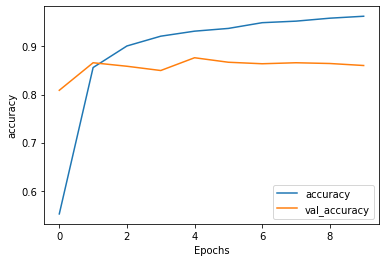

In [21]:
plot_graphs(history, 'accuracy')

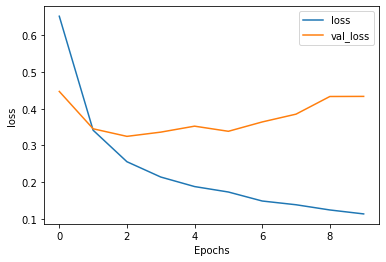

In [22]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 72s 185ms/step - loss: 0.6648 - accuracy: 0.5468 - val_loss: 0.5265 - val_accuracy: 0.7516
Epoch 2/10
391/391 [==============================] - 71s 183ms/step - loss: 0.4028 - accuracy: 0.8272 - val_loss: 0.4052 - val_accuracy: 0.8068
Epoch 3/10
391/391 [==============================] - 71s 182ms/step - loss: 0.2788 - accuracy: 0.8962 - val_loss: 0.3423 - val_accuracy: 0.8552
Epoch 4/10
391/391 [==============================] - 72s 184ms/step - loss: 0.2250 - accuracy: 0.9188 - val_loss: 0.3658 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 73s 187ms/step - loss: 0.1916 - accuracy: 0.9358 - val_loss: 0.3929 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 75s 191ms/step - loss: 0.1678 - accuracy: 0.9464 - val_loss: 0.3752 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 75s 191ms/step - loss: 0.1469 - accuracy: 0.9559 - val_loss: 0.4843 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 31s 80ms/step - loss: 0.4796 - accuracy: 0.8505
Test Loss: 0.47960710525512695
Test Accuracy: 0.8504800200462341


In [27]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.6095185]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.1003203]]


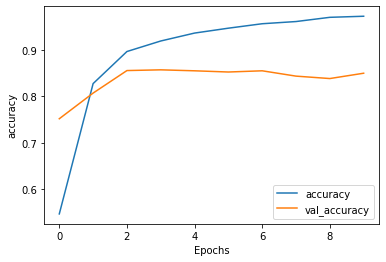

In [29]:
plot_graphs(history, 'accuracy')

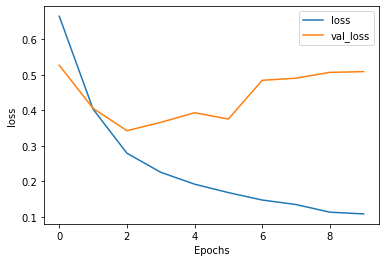

In [30]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
